In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import time

from collections import deque
import time
import random
from tqdm import tqdm
import os
from PIL import Image
import cv2
import pandas as pd


In [9]:
DISCOUNT = 0.99
REPLAY_MEMORY_SIZE = 50000  # How many last steps to keep for model training
MIN_REPLAY_MEMORY_SIZE = 300  # Minimum number of steps in a memory to start training
#MINIBATCH_SIZE = 64  # How many steps (samples) to use for training

#MINIBATCH_SIZE = 8  Duży skok
MINIBATCH_SIZE = 16


#UPDATE_TARGET_EVERY = 10  # Terminal states (end of episodes)


UPDATE_TARGET_EVERY = 2  # Terminal states (end of episodes)

MODEL_NAME = 'window48_profit'
MIN_REWARD = -200  # For model save
MEMORY_FRACTION = 0.20

# Environment settings
EPISODES = 1000

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.99975
MIN_EPSILON = 0.001

#  Stats settings
AGGREGATE_STATS_EVERY = 10  # episodes
SHOW_PREVIEW = True

# For stats
ep_rewards = [-200]

# For more repetitive results
random.seed(1)

# Memory fraction, used mostly when trai8ning multiple agents
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=MEMORY_FRACTION)
#backend.set_session(tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)))

# Create models folder
if not os.path.isdir('models'):
    os.makedirs('models')




In [10]:
import gym
from gym import spaces
import numpy as np

class TimeSeriesEnv(gym.Env):
    def __init__(self, data, window_size=10):
        super(TimeSeriesEnv, self).__init__()
        self.data = data
        self.window_size = window_size
        self.current_step = window_size

        self.action_space = spaces.Discrete(3)  # 0 = hold, 1 = buy, 2 = sell
        self.observation_space = spaces.Box(
            low=0.0, high=1.0, shape=(window_size,), dtype=np.float32
        )

        self.inventory = []
        self.total_profit = 0.0
        self.states_buy = []
        self.states_sell = []
        self.action_reward = 0
        #self.max_size = 10
        
        self.min_val = np.min(data)
        self.max_val = np.max(data)

    def reset(self):
        self.current_step = self.window_size
        self.inventory = []
        self.total_profit = 0.0
        self.states_buy = []
        self.states_sell = []
        return self._get_observation()

    def _get_observation(self):
        past = self.data[self.current_step - self.window_size:self.current_step]
        #future = self.data[self.current_step:self.current_step + self.future_size]
        #obs = np.concatenate([past, future])

        self.min_val = np.min(past)
        self.max_val = np.max(past)
        return ((past - self.min_val) / (self.max_val - self.min_val + 1e-8)).astype(np.float32)

    def step(self, action):
        done = False
        reward = 0.0
        price = self.data[self.current_step]

        if action == 1:  # Buy
            self.inventory.append(price)
            self.states_buy.append(self.current_step)
            # Brak nagrody za samo kupno

        elif action == 2 and len(self.inventory) > 0:  # Sell
            bought_price = self.inventory.pop(0)
            profit = price - bought_price
            reward = profit #max(profit, 0)  # Możesz dać też samo `reward = profit` jeśli chcesz karać stratę
            self.total_profit += profit
            #reward = self.total_profit
            self.states_sell.append(self.current_step)

        # Hold (0) nic nie robi
        self.current_step += 1

        if self.current_step >= len(self.data):
            done = True
            if len(self.inventory) > 0:
                self.total_profit += np.sum(self.data[-1] - np.array(self.inventory, dtype=np.float32))


        return self._get_observation(), reward, done


In [11]:
# from source.IB_connector import retrive_market_data
# ticker = 'AAPL'
# training_set_aapl = retrive_market_data([ticker], duration = "9 m", time_interval = "15 mins")
# training_set = training_set_aapl[ticker]
# training_set['Volume'] = training_set['Volume'].astype(float)
# training_set['Date'] = pd.to_datetime(training_set['Date'].str.replace(' US/Eastern',''),format="%Y%m%d %H:%M:%S")


In [12]:
# training_set['ticker'] = ticker

In [13]:
# from source.database import upload_stock_data, read_stock_data

# upload_stock_data(training_set)

In [14]:
# col_select = ['Open','High','Low','Close','Volume']
# training_set = training_set[col_select]
# training_set.dtypes
# CLOSE_INDEX = col_select.index('Close')

In [15]:
# import pandas as pd
# df = pd.read_csv('data/SP500.csv')
# data = df['Close'].values
# # # data

In [16]:
#len(data)  * 0.8

In [35]:

#add_trend = np.logspace(np.log(1.08), np.log(2), 500, base=np.exp(2))
data = np.sin(np.linspace(0, 500, 2500)).astype(np.float32)# + add_trend
#data = training_set['Close'].values
data_split = int(len(data)  * 0.8)
train_data = data[:data_split]
valid_data = data[data_split:]

WINDOW_SIZE = 96
env = TimeSeriesEnv(train_data, window_size=WINDOW_SIZE)
valid_env = TimeSeriesEnv(valid_data,window_size=WINDOW_SIZE)

In [36]:
env.reset()

array([0.50010157, 0.5994995 , 0.6949317 , 0.7825903 , 0.858978  ,
       0.92104703, 0.96632093, 0.99299335, 1.        , 0.9870613 ,
       0.9546937 , 0.90418845, 0.83756065, 0.7574687 , 0.6671082 ,
       0.5700843 , 0.47026813, 0.37164238, 0.27814195, 0.19349739,
       0.12108593, 0.06379671, 0.02391545, 0.00303336, 0.00198365,
       0.02080813, 0.05875583, 0.11431258, 0.18526182, 0.26877275,
       0.36151335, 0.45978346, 0.55966216, 0.6571645 , 0.74840033,
       0.82972926, 0.89790654, 0.950212  , 0.9845585 , 0.999576  ,
       0.994665  , 0.97002167, 0.9266292 , 0.86621875, 0.79120076,
       0.7045683 , 0.6097779 , 0.5106116 , 0.4110259 , 0.31499425,
       0.22634813, 0.14862438, 0.0849241 , 0.03778887, 0.00909927,
       0.        , 0.0108541 , 0.04122853, 0.08991136, 0.15496024,
       0.23377979, 0.32322523, 0.4197278 , 0.51943713, 0.61837506,
       0.71259403, 0.7983348 , 0.87217647, 0.93117285, 0.9729701 ,
       0.9959006 , 0.99904925, 0.9822906 , 0.94629335, 0.89249

In [37]:
done = 0
env.reset()
count_steps = 0
while not done:
    new_state, reward, done = env.step(1)
    count_steps +=1

count_steps

1904

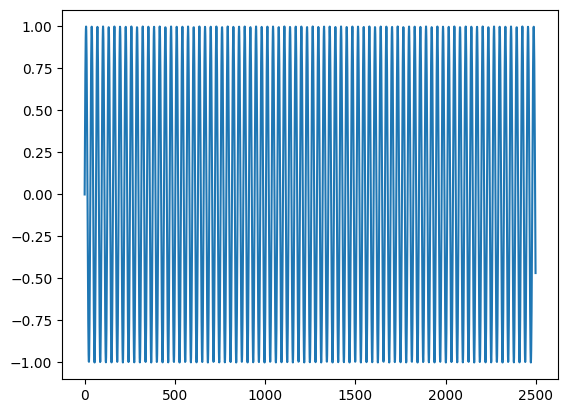

In [38]:
import matplotlib.pyplot as plt

plt.plot(data)

In [21]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Prosta sieć neuronowa w PyTorchu
# class DQN(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(DQN, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 32)
#         self.fc2 = nn.Linear(32, 16)
#         self.fc3 = nn.Linear(16, 8)
#         self.output = nn.Linear(8, output_dim)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.relu(self.fc3(x))
#         return self.output(x)

#Window - 48
# class DQN(nn.Module):
# 	def __init__(self, input_dim, output_dim):
# 		super(DQN, self).__init__()
# 		self.out_steps = output_dim

# 		self.lstm = nn.LSTM(input_size=input_dim, hidden_size=48, batch_first=True)
# 		self.dropout = nn.Dropout(p=0.4)

# 		self.fc = nn.Linear(48, 32)
# 		self.fc2 = nn.Linear(32, 24)
# 		self.fc3 = nn.Linear(24, 16)
# 		self.fc4 = nn.Linear(16, output_dim)

# 	def forward(self, x):
# 		#_, (h_n, _) = self.lstm(x)  # h_n: [1, batch, lstm_units]
# 		h_n, _ = self.lstm(x)  # h_n: [1, batch, lstm_units]

# 		h_n = h_n.squeeze(0)        # [batch, lstm_units]
# 		#h_n = self.dropout(h_n)        # [batch, lstm_units]

# 		x = torch.relu(self.fc(h_n))            # [batch, out_steps * num_features]
# 		x = torch.relu(self.fc2(x))            # [batch, out_steps * num_features]
# 		x = torch.relu(self.fc3(x))            # [batch, out_steps * num_features]

  
# 		#x = self.dropout(x)            # [batch, out_steps * num_features]
  
# 		x = self.fc4(x)		# [out_steps * num_features, close_price]
# 		#x = self.dropout(x)            # [batch, out_steps * num_features]

# 		x = x.view(-1, self.out_steps, 1)
# 		return x

#window 96
# class DQN(nn.Module):
# 	def __init__(self, input_dim, output_dim):
# 		super(DQN, self).__init__()
# 		self.out_steps = output_dim

# 		self.lstm = nn.LSTM(input_size=input_dim, hidden_size=64, batch_first=True)
# 		self.dropout = nn.Dropout(p=0.4)

# 		self.fc = nn.Linear(64, 48)
# 		self.fc2 = nn.Linear(48, 24)
# 		self.fc3 = nn.Linear(24, 16)
# 		self.fc4 = nn.Linear(16, output_dim)

# 	def forward(self, x):
# 		#_, (h_n, _) = self.lstm(x)  # h_n: [1, batch, lstm_units]
# 		h_n, _ = self.lstm(x) 
# 		h_n = h_n.squeeze(0)        
# 		x = torch.relu(self.fc(h_n))            
# 		x = self.dropout(x)
# 		x = torch.relu(self.fc2(x))
# 		x = self.dropout(x)
# 		x = torch.relu(self.fc3(x))
# 		x = self.dropout(x)
# 		x = self.fc4(x)
# 		x = x.view(-1, self.out_steps, 1)
# 		return x


class DQN(nn.Module):
	def __init__(self, input_dim, output_dim):
		super(DQN, self).__init__()
		self.out_steps = output_dim

		self.lstm = nn.LSTM(input_size=input_dim, hidden_size=8, batch_first=True)
		self.dropout = nn.Dropout(p=0.2)
		self.fc4 = nn.Linear(8, output_dim)

	def forward(self, x):
		#_, (h_n, _) = self.lstm(x)  # h_n: [1, batch, lstm_units]
		h_n, _ = self.lstm(x) 
		h_n = h_n.squeeze(0)

		x = self.fc4(h_n)
		x = x.view(-1, self.out_steps, 1)
		return x



# W = (96 + 8)*2 * log(96 + 8) 

class DQNAgent:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.observarion_space = 96
        self.action_space = 3
        
        self.model = DQN(self.observarion_space, self.action_space).to(self.device)
        self.target_model = DQN(self.observarion_space, self.action_space).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()

        #self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001, weight_decay=1e-2)
        self.loss_fn = nn.MSELoss()


        self.REPLAY_MEMORY_SIZE = 50000
        self.MIN_REPLAY_MEMORY_SIZE = 300 
        self.replay_memory = deque(maxlen=self.REPLAY_MEMORY_SIZE)
        self.target_update_counter = 0
        
        #model setings
        self.UPDATE_TARGET_EVERY = 2
        self.MINIBATCH_SIZE = 16
        self.DISCOUNT = 0.99
        
        self.AGGREGATE_STATS_EVERY = 10
        
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    def train(self, terminal_state):
        if len(self.replay_memory) < self.MIN_REPLAY_MEMORY_SIZE:
            return

        minibatch = random.sample(self.replay_memory, self.MINIBATCH_SIZE)

        # Rozpakowanie danych
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states_v = torch.from_numpy(np.array(states)).float().to(self.device)
        next_states_v = torch.from_numpy(np.array(next_states)).float().to(self.device)
        actions_v = torch.tensor(actions, dtype=torch.int64, device=self.device)
        rewards_v = torch.tensor(rewards, dtype=torch.float32, device=self.device)
        dones_v = torch.tensor(dones, dtype=torch.bool, device=self.device)        
        
        with torch.no_grad():
            target_qs = self.target_model(next_states_v).flatten(start_dim=1)
            max_future_qs = torch.max(target_qs, dim=1)[0]
            new_qs = rewards_v + (~dones_v * self.DISCOUNT * max_future_qs)

        current_qs = self.model(states_v).flatten(start_dim=1)
        predicted_qs = current_qs.gather(1, actions_v.unsqueeze(1)).squeeze()

        loss = self.loss_fn(predicted_qs, new_qs)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if terminal_state:
            self.target_update_counter += 1

        if self.target_update_counter > self.UPDATE_TARGET_EVERY:
            self.target_model.load_state_dict(self.model.state_dict())
            self.target_update_counter = 0

    def get_qs(self, state):
        state_v = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        with torch.no_grad():
            qs = self.model(state_v)
        return qs #.cpu().numpy()[0]


def evaluate_steps(env, model, device="cuda:0"):
    state = env.reset()
    total_reward = 0
    done = False
    steps = 0
    action = 0
    while not done:
        # konwersja stanu na tensora
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        with torch.no_grad():
            q_values = model(state_tensor)
            action = torch.argmax(q_values).item()

        state, reward, done = env.step(action)
        total_reward += reward
        steps += 1
        #print(f"Krok: {steps}, Akcja: {action}, Nagroda: {reward:.2f}, Łączny zysk: {env.total_profit:.2f}")

    #print(state_tensor)
    return total_reward

In [41]:
import math

model = DQN(96,3)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

VCD_UPPER = int(2 * trainable_params * math.log(trainable_params))

#VCD_LOWER = 2 * 
print(VCD_UPPER, "minimalna liczba próbek -",VCD_UPPER*10 )

55641 minimalna liczba próbek - 556410


In [42]:
from copy import deepcopy
agent = DQNAgent()
reward_all = []
evaluate_revards = []


In [43]:
import multiprocessing
from torch.distributions import Categorical


#EPSILON_DECAY = 0.998
EPSILON_DECAY = 0.99

def train_episode(episode, epsilon):
    # Update tensorboard step every episode
    #agent.tensorboard.step = episode

    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1

    # Reset environment and get initial state
    current_state = env.reset()

    # Reset flag and start iterating until episode ends
    done = False
    while not done:

        # This part stays mostly the same, the change is to query a model for Q values
        if np.random.random() > epsilon:
            # Get action from Q table
            #action = np.argmax(agent.get_qs(current_state))
            probs = torch.softmax(agent.get_qs(current_state).squeeze(), dim=0)
            dist = Categorical(probs)
            action = dist.sample().item()  # zamiast .numpy()[0]
            #print(action)
        else:
            # Get random action
            action = np.random.randint(0, env.action_space.n)

        new_state, reward, done = env.step(action)

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward


        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        
        #0.5 spoko dla 100 batch, ciągle losowao jak idiz esie dalej(bez dropout), batch size 8, EPSILON_DECAY = 0.99 
        
        #0.5 spoko dla 100 batch, ciągle losowao jak idiz esie dalej(z dropout), batch size 8, EPSILON_DECAY = 0.99 - lepiej, większy zysk
        
        #0.7 TOP dla 100 batch, ciągle losowao jak idiz esie dalej(z dropout), batch size 8, EPSILON_DECAY = 0.99 - lepiej, większy zysk
        if np.random.random() >= .7:
            agent.train(done)

        current_state = new_state
        step += 1
 
    # Append episode reward to a list and log stats (every given number of episodes)
    ep_rewards.append(episode_reward)
    if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
            print(f"Episode: {episode} Total Reward: {env.total_profit} Epsilon: {epsilon:.2f}")

    
    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        #agent.tensorboard.update_stats(reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon)

        # Save model, but only when min reward is greater or equal a set value
        #if min_reward >= MIN_REWARD:
        #    agent.model.save(f'models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.h5')


    return episode_reward

#super dla 200, batch64
EPISODES = 200
# Iterate over episodes
max_agent = DQNAgent()
max_reward = 0
evaluate_every = 1
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):
    reward = train_episode(episode,epsilon)
    
    
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)

    
    reward_all.append(reward)
    #if episode % evaluate_every:
    valid_env.reset()
    reward_valid_dataset = evaluate_steps(valid_env, agent.target_model)
    evaluate_revards.append(reward_valid_dataset)
    
    if reward_valid_dataset > max_reward and episode > 10:
        max_reward = reward_valid_dataset
        #print(max_reward)
        max_agent = deepcopy(agent)
    
    #print(reward_valid_dataset)
    if max_reward > 0 and episode > 10 and reward_valid_dataset / max_reward <= .7:
        agent = deepcopy(max_agent)

    
#bierz Q z target modelu
    

#przed opt - 18 min

  4%|4         | 9/200 [00:40<14:18,  4.49s/episodes]

Episode: 10 Total Reward: 171.39778574742377 Epsilon: 0.09


 10%|9         | 19/200 [01:24<14:18,  4.74s/episodes]

Episode: 20 Total Reward: 214.49704430252314 Epsilon: 0.09


 14%|#4        | 29/200 [02:09<12:24,  4.36s/episodes]

Episode: 30 Total Reward: 145.93021311610937 Epsilon: 0.08


 16%|#6        | 33/200 [02:27<12:28,  4.48s/episodes]


KeyboardInterrupt: 

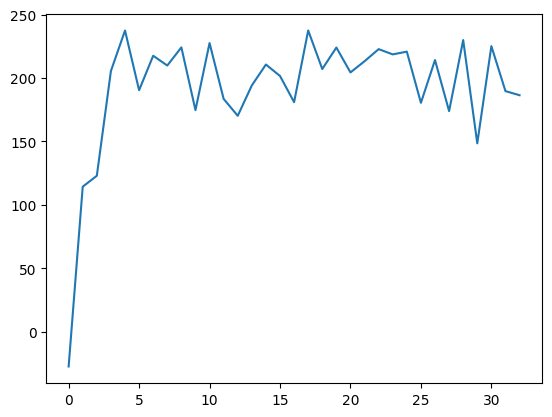

In [44]:
import matplotlib.pyplot as plt
plt.plot(reward_all)

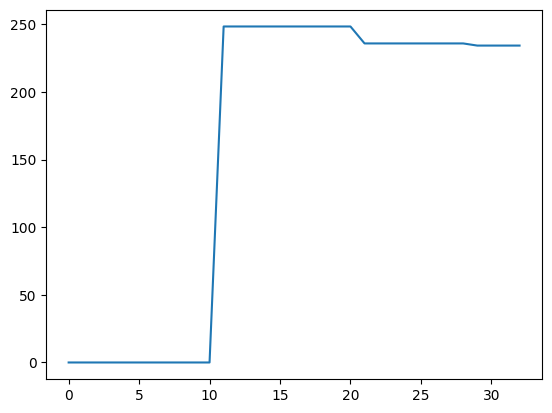

In [45]:
import matplotlib.pyplot as plt
plt.plot(evaluate_revards)

In [48]:
from rl_agent import save_dqn_agent, load_dqn_agent

save_dqn_agent(max_agent, 'sinus_trader.pth')

In [ ]:
# from multiprocessing import Pool
# from tqdm import tqdm

# def train_wrapper(episode, epsilon):
#     return train_episode(episode, epsilon)

# if __name__ == "__main__":
#     with Pool() as pool:
#         results = list(tqdm(pool.starmap(train_wrapper, [(episode, epsilon) for episode in range(1, EPISODES + 1)]), total=EPISODES, ascii=True, unit='episodes'))

c:\Users\proso\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1410.)
  result = _VF.lstm(


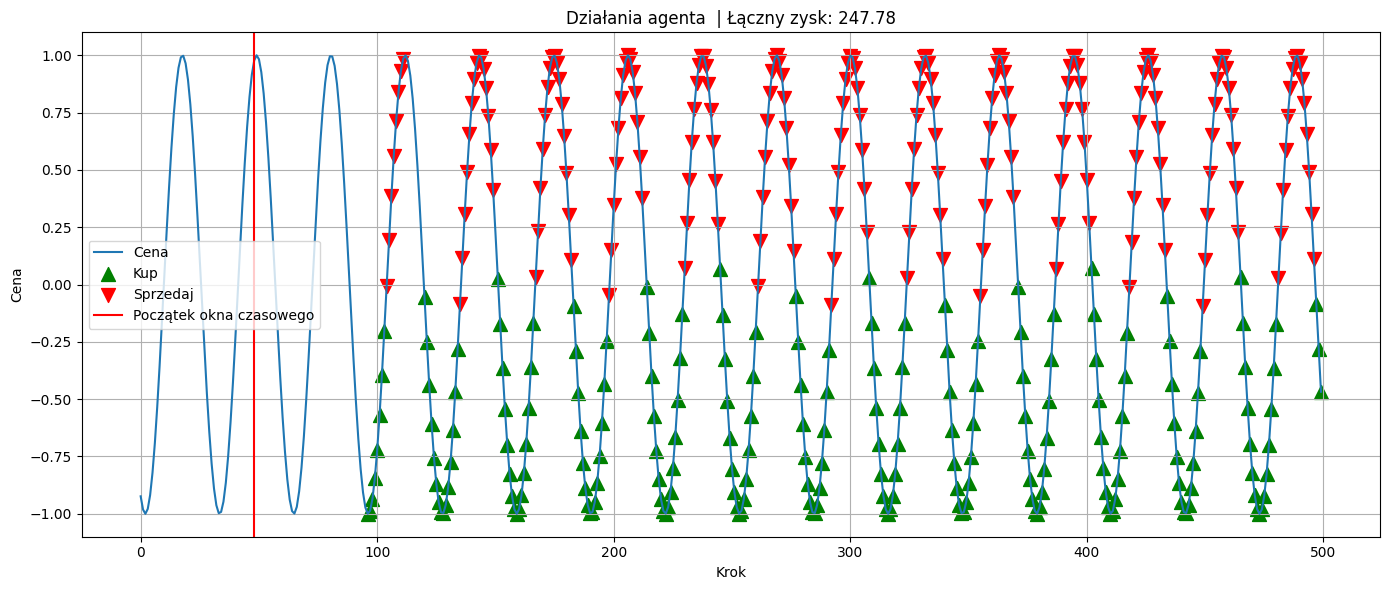

In [46]:
import torch
import matplotlib.pyplot as plt


def evaluate_steps(env, model, device="cuda:0"):
    state = env.reset()
    total_reward = 0
    done = False
    steps = 0
    action = 0
    while not done:
        # konwersja stanu na tensora
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        with torch.no_grad():
            q_values = model(state_tensor)
            action = torch.argmax(q_values).item()

        state, reward, done = env.step(action)
        total_reward += reward
        steps += 1
        #print(f"Krok: {steps}, Akcja: {action}, Nagroda: {reward:.2f}, Łączny zysk: {env.total_profit:.2f}")

    #print(state_tensor)
    return total_reward


def render_env(env, title_suffix="", window_size = 48):
    prices = env.data
    buy_points = env.states_buy
    sell_points = env.states_sell
    profit = env.total_profit

    plt.figure(figsize=(14, 6))
    plt.plot(prices, label='Cena', linewidth=1.5)

    if buy_points:
        plt.scatter(buy_points, [prices[i] for i in buy_points],
                    color='green', marker='^', label='Kup', s=100)
    if sell_points:
        plt.scatter(sell_points, [prices[i] for i in sell_points],
                    color='red', marker='v', label='Sprzedaj', s=100)

    plt.title(f'Działania agenta {title_suffix} | Łączny zysk: {profit:.2f}')
    plt.axvline(x = window_size, color = 'red', label = 'Początek okna czasowego')
    plt.xlabel('Krok')
    plt.ylabel('Cena')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

##8847 - duża sieć
##89996
# AAPL 848
# AAPL 357 DUŻA SIEĆ
# AAPL 938 96 LSTM, 8 fc
env.reset()
evaluate_steps(valid_env, max_agent.target_model)
render_env(valid_env, title_suffix="")

In [ ]:
from rl_agent import save_dqn_agent, load_dqn_agent
#load_dqn_agent(agent, 'aapl_best_agent_vc_dimOPT.pth')

Model załadowany z aapl_best_agent_vc_dimOPT.pth


c:\programowanie\trade_opt\rl_agent.py:195: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location=torch.device("cuda" if torch.cuda.is

In [32]:
from source.IB_connector import retrive_market_data
ticker = 'AAPL'
training_set_aapl = retrive_market_data([ticker], duration = "1 m", time_interval = "15 mins")
training_set = training_set_aapl[ticker]
training_set['Volume'] = training_set['Volume'].astype(float)
training_set['Date'] = pd.to_datetime(training_set['Date'].str.replace(' US/Eastern',''),format="%Y%m%d %H:%M:%S")
col_select = ['Open','High','Low','Close','Volume']
training_set = training_set[col_select]
training_set.dtypes
CLOSE_INDEX = col_select.index('Close')

ERROR -1 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefil


Found window with title: DUK343627 Interactive Brokers (Simulated Trading)


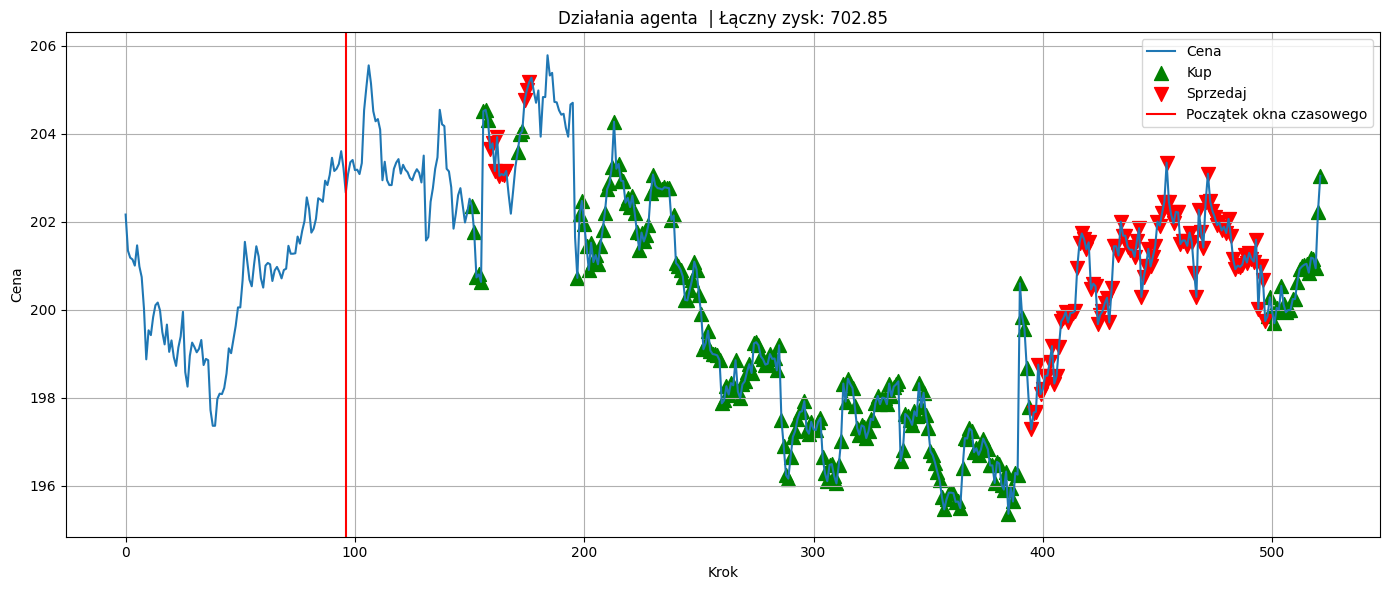

In [33]:
env = TimeSeriesEnv(data=training_set['Close'].values, window_size=WINDOW_SIZE)

env.reset()
evaluate_steps(env, agent.target_model)
render_env(env, title_suffix="", window_size=WINDOW_SIZE)